# TP1 : Détection d’anomalies avec Python

---
---

## I. Import des librairies

In [121]:
import numpy as np
np.set_printoptions(threshold=10000, suppress = True)

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerPathCollection
%matplotlib inline

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.inspection import DecisionBoundaryDisplay

## II. Base de données Mouse

### A. Chargement et analyse rapide

In [105]:
mouse_data = pd.read_table("mouse.txt", sep=" ", names=['x1', 'x2'])
print(mouse_data)

           x1        x2
0    0.456601  0.432806
1    0.611378  0.528625
2    0.450299  0.711606
3    0.639015  0.460744
4    0.628957  0.323470
..        ...       ...
495  0.151506  0.876586
496  0.860308  0.633833
497  0.862083  0.591805
498  0.916030  0.523391
499  0.427325  0.833767

[500 rows x 2 columns]


In [62]:
print(mouse_data.describe())

               x1          x2
count  500.000000  500.000000
mean     0.505892    0.599706
std      0.191763    0.156863
min      0.040555    0.138940
25%      0.328481    0.469010
50%      0.504702    0.629494
75%      0.681430    0.735364
max      0.916030    0.897028


In [63]:
max_x1 = mouse_data['x1'].max()
max_x2 = mouse_data['x2'].max()
min_x1 = mouse_data['x1'].min()
min_x2 = mouse_data['x2'].min()

print(f"Max x1: {max_x1}")
print(f"Max x2: {max_x2}")
print(f"Min x1: {min_x1}")
print(f"Min x2: {min_x2}")

Max x1: 0.916029808381927
Max x2: 0.897027660749859
Min x1: 0.0405549277447862
Min x2: 0.1389403881484


### B. Représentation graphique

Text(0.5, 1.0, 'Scatter plot des coordonnées de mouse.txt')

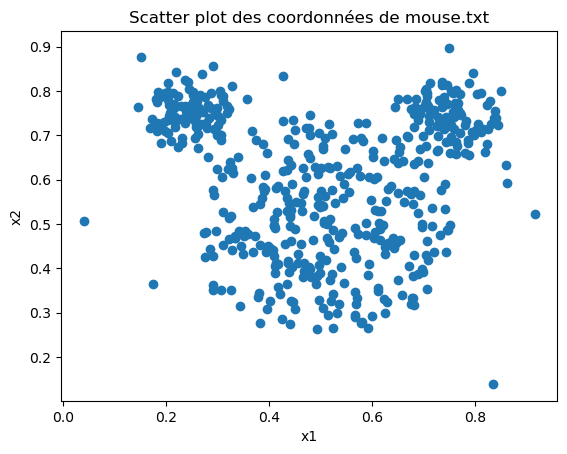

In [64]:
plt.scatter(mouse_data['x1'], mouse_data['x2'])
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Scatter plot des coordonnées de mouse.txt')

### C. Détection d'outlier par Isolation Forest

#### 1. Principe de l'algo

Isolation Forest est un algorithme d'apprentissage non supervisé utilisé pour détecter des anomalies ou des points de données qui sont différents (outliers) dans un ensemble de données. Il est particulièrement efficace pour travailler avec de grandes quantités de données et peut détecter des anomalies sans avoir besoin d'étiquettes (comme dans le cas des anomalies non étiquetées).

L'idée fondamentale derrière l'Isolation Forest repose sur l'idée que les anomalies sont plus faciles à "isoler" que les points normaux. Les anomalies sont souvent éloignées de la majorité des données, ce qui les rend plus faciles à séparer lors de la construction de "arbres" d'isolation.

Voici comment fonctionne l'algorithme :

- Isolation des points de données :
    - Le modèle crée plusieurs arbres (similaires à un arbre de décision), où chaque arbre "divise" les données de manière aléatoire. Pour chaque point, l'algorithme essaie de le séparer des autres points.
    - Les anomalies (points rares ou extrêmes) nécessitent moins de divisions pour être séparées des autres points. En d'autres termes, elles sont plus facilement "isolées" dans les arbres.

- Scores d'anomalie :
    - Chaque point de données reçoit un score d'anomalie basé sur le nombre de divisions nécessaires pour l'isoler. Plus un point a un score élevé, plus il est probable que ce soit une anomalie.
    - Le score est compris entre -1 et 1. Les points avec un score proche de -1 sont considérés comme des anomalies, tandis que ceux proches de 1 sont considérés comme normaux.

#### 2. Arguments de la fonction

- n_estimators :
    - Description : Le nombre d'arbres à utiliser dans la forêt.
    - Valeur par défaut : 100
    - Explication : Plus le nombre d'arbres est élevé, plus l'algorithme est susceptible de donner des résultats stables, mais cela augmentera aussi le temps de calcul. Un nombre typique est entre 100 et 200.

- max_samples :
    - Description : Le nombre maximum de points à utiliser pour entraîner chaque arbre.
    - Valeur par défaut : 'auto' (qui correspond à min(256, n_samples)).
    - Explication : Si tu as un grand nombre de points, tu peux réduire ce paramètre pour accélérer l'entraînement. Utiliser la valeur par défaut est souvent suffisant pour la plupart des cas, mais tu peux ajuster ce paramètre si tu travailles avec des ensembles de données très grands.

- contamination :
    - Description : La proportion estimée d'anomalies dans les données. Ce paramètre aide à déterminer quel seuil utiliser pour classer un point comme anomalie.
    - Valeur par défaut : 0.1 (10% des données seront considérées comme des anomalies).
    - Explication : Si tu sais approximativement quelle proportion de points dans ton ensemble de données est anormale, tu peux fournir cette valeur pour améliorer la détection des anomalies. Si tu ne connais pas cette proportion, laisse ce paramètre à sa valeur par défaut, mais il peut être nécessaire de l'ajuster en fonction de ton jeu de données.

- max_features :
    - Description : Le nombre maximum de caractéristiques (features) à utiliser pour entraîner chaque arbre.
    - Valeur par défaut : 1.0 (toutes les caractéristiques sont utilisées).
    - Explication : Cela peut être utile si tu as un grand nombre de dimensions (features) et que tu veux réduire le calcul en ne prenant qu'un sous-ensemble aléatoire de caractéristiques à chaque itération.

- bootstrap :
    - Description : Si True, chaque arbre est entraîné sur un échantillon aléatoire avec remplacement (bootstrap sampling).
    - Valeur par défaut : False
    - Explication : Cela peut être utile si tu veux entraîner les arbres sur des échantillons plus variés (mais cela pourrait affecter la performance).

- n_jobs :
    - Description : Le nombre de threads à utiliser pour entraîner les arbres.
    - Valeur par défaut : 1
    - Explication : Si tu veux accélérer le calcul, tu peux spécifier un nombre plus élevé de threads (par exemple, -1 pour utiliser tous les cœurs du processeur).

- random_state :
    - Description : Un nombre ou un objet pour contrôler la randomisation. Il permet de fixer la graine du générateur de nombres aléatoires pour garantir que les résultats soient reproductibles.
    - Valeur par défaut : None
    - Explication : Si tu veux que tes résultats soient reproductibles à chaque exécution, tu peux définir ce paramètre à un nombre fixe (par exemple, random_state=42).

- decision_function :
    - Description : Ce paramètre peut être utilisé pour obtenir la "fonction de décision" qui donne la confiance du modèle sur le fait qu'un point est une anomalie ou non.
    - Explication : Cela peut être utilisé pour obtenir un score pour chaque observation avant de décider de sa classification finale en anomalie.

#### 3. Construction du modèle

In [106]:
mouse_data_1 = mouse_data

iso_forest_model = IsolationForest(
    n_estimators=100, 
    max_samples='auto', 
    contamination='auto', 
    max_features=1.0, 
    bootstrap=False,
    n_jobs=None, 
    random_state=None, 
    verbose=True, 
    warm_start=False)

iso_forest_model.fit(mouse_data_1)

IsolationForest(verbose=True)

In [107]:
# Prédire les anomalies
mouse_data_1['anomaly'] = iso_forest_model.predict(mouse_data_1)  # -1 pour outliers, 1 pour normales

# Séparer les points normaux des outliers
normals = mouse_data_1[mouse_data['anomaly'] == 1]
outliers = mouse_data_1[mouse_data['anomaly'] == -1]

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


#### 4. Visualisation des outliers

##### a. Représentation basique

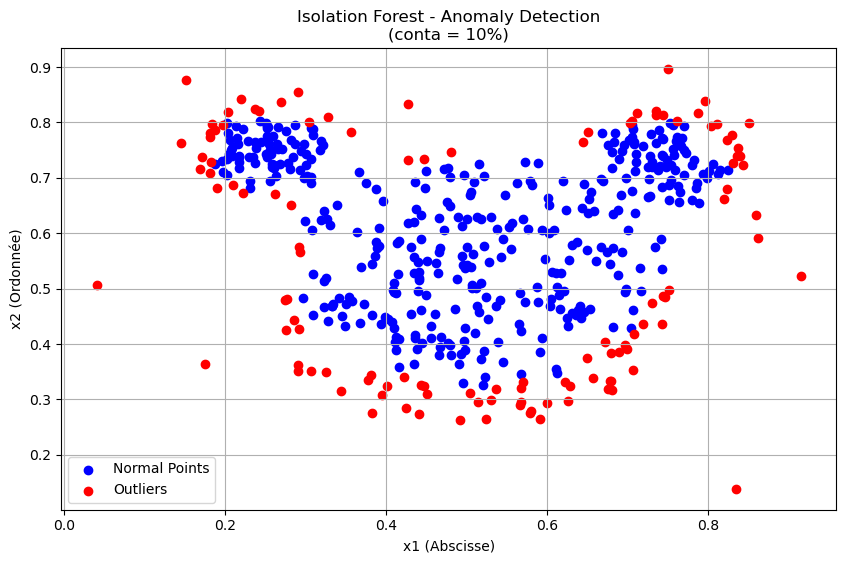

In [108]:
plt.figure(figsize=(10, 6))
plt.scatter(normals['x1'], normals['x2'], color='blue', label='Normal Points')
plt.scatter(outliers['x1'], outliers['x2'], color='red', label='Outliers')
plt.xlabel('x1 (Abscisse)')
plt.ylabel('x2 (Ordonnée)')
plt.legend()
plt.title('Isolation Forest - Anomaly Detection\n(conta = 10%)')
plt.grid(True)

##### b. Représentation avec des frontières

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


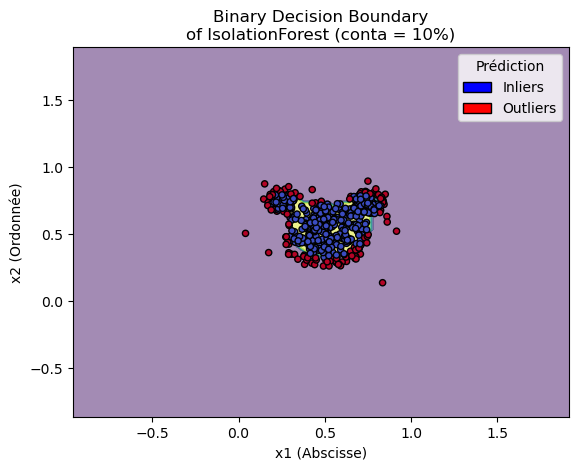

In [109]:
y_pred = mouse_data_1['anomaly'].replace({1: 0, -1: 1})  # 0 pour inliers, 1 pour outliers (pour le graphique)

# Visualisation des frontières de décision
disp = DecisionBoundaryDisplay.from_estimator(
    iso_forest_model,
    mouse_data_1[["x1", "x2"]],
    response_method="predict",
    alpha=0.5,
)
disp.ax_.scatter(mouse_data_1["x1"], mouse_data_1["x2"], c=y_pred, cmap="coolwarm", s=20, edgecolor="k")
disp.ax_.set_title("Binary Decision Boundary\nof IsolationForest (conta = 10%)")
disp.ax_.set_xlabel("x1 (Abscisse)")
disp.ax_.set_ylabel("x2 (Ordonnée)")
# plt.legend(["Inliers", "Outliers"], loc="upper right")

# Création d'une légende manuelle
legend_elements = [
    Patch(facecolor="blue", edgecolor="k", label="Inliers"),
    Patch(facecolor="red", edgecolor="k", label="Outliers"),
]
disp.ax_.legend(handles=legend_elements, loc="upper right", title="Prédiction")

#### 5. Amélioration du seuil de contamination

À propos de mouse.txt, on nous dit : 
>Ce fichier contient 500 instances décrites par deux variables x1 et x2 représentant des points de la tête de Mickey Mouse. Les 10 dernières instances du fichier sont aberrantes (outliers).

On a donc $\frac{10}{500}=2\%$ d'outliers

On peut donc modifier l'argument `contamination` de la fonction `IsolationForest()` lors de la construction du modèle, qui par défaut vaut 10%.

In [132]:
mouse_data_1_bis = pd.read_table("mouse.txt", sep=" ", names=['x1', 'x2'])

iso_forest_model_1_bis = IsolationForest(
    n_estimators=100, 
    max_samples='auto', 
    contamination=0.02, 
    max_features=1.0, 
    bootstrap=False, 
    n_jobs=None, 
    random_state=None, 
    verbose=True, 
    warm_start=False)

iso_forest_model_1_bis.fit(mouse_data_1_bis)

# Prédire les anomalies
mouse_data_1_bis['anomaly'] = iso_forest_model_1_bis.predict(mouse_data_1_bis)  # -1 pour outliers, 1 pour normales

# Séparer les points normaux des outliers
normals_1_bis = mouse_data_1_bis[mouse_data_1_bis['anomaly'] == 1]
outliers_1_bis = mouse_data_1_bis[mouse_data_1_bis['anomaly'] == -1]

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


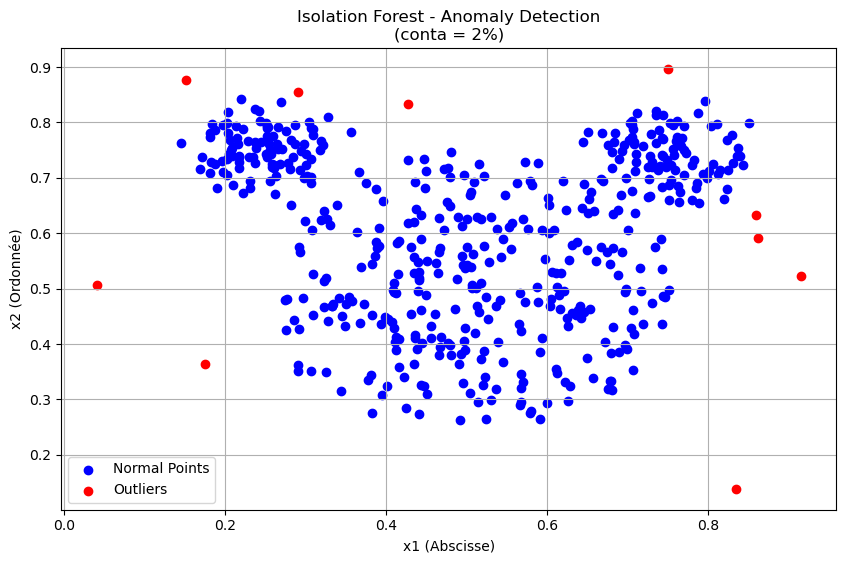

In [133]:
plt.figure(figsize=(10, 6))
plt.scatter(normals_1_bis['x1'], normals_1_bis['x2'], color='blue', label='Normal Points')
plt.scatter(outliers_1_bis['x1'], outliers_1_bis['x2'], color='red', label='Outliers')
plt.xlabel('x1 (Abscisse)')
plt.ylabel('x2 (Ordonnée)')
plt.legend()
plt.title('Isolation Forest - Anomaly Detection\n(conta = 2%)')
plt.grid(True)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


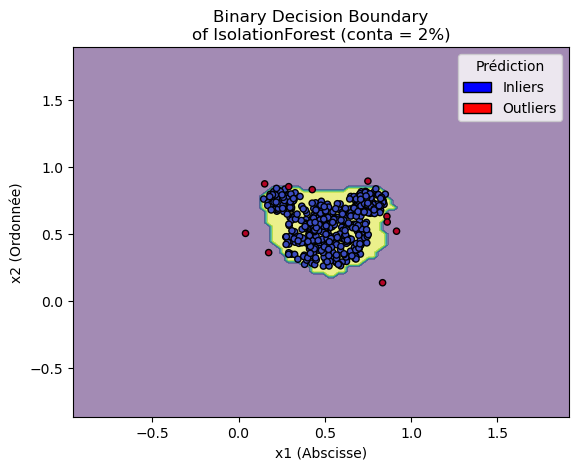

In [134]:
y_pred_1_bis = mouse_data_1_bis['anomaly'].replace({1: 0, -1: 1})  # 0 pour inliers, 1 pour outliers (pour le graphique)

# Visualisation des frontières de décision
disp_1_bis = DecisionBoundaryDisplay.from_estimator(
    iso_forest_model_1_bis,
    mouse_data_1_bis[["x1", "x2"]],
    response_method="predict",
    alpha=0.5,
)
disp_1_bis.ax_.scatter(mouse_data_1_bis["x1"], mouse_data_1_bis["x2"], c=y_pred_1_bis, cmap="coolwarm", s=20, edgecolor="k")
disp_1_bis.ax_.set_title("Binary Decision Boundary\nof IsolationForest (conta = 2%)")
disp_1_bis.ax_.set_xlabel("x1 (Abscisse)")
disp_1_bis.ax_.set_ylabel("x2 (Ordonnée)")
# plt.legend(["Inliers", "Outliers"], loc="upper right")

# Création d'une légende manuelle
legend_elements_1_bis = [
    Patch(facecolor="blue", edgecolor="k", label="Inliers"),
    Patch(facecolor="red", edgecolor="k", label="Outliers"),
]
disp_1_bis.ax_.legend(handles=legend_elements2, loc="upper right", title="Prédiction")

### D. Détection d'outlier par Local Outlier Factor (LOF)

#### 1. Modèle LOF avec contamination par défaut

##### a. Model training

In [120]:
mouse_data_lof_1 = pd.read_table("mouse.txt", sep=" ", names=['x1', 'x2'])

Lof_model_1 = LocalOutlierFactor(
    n_neighbors=20,
    algorithm='auto', 
    leaf_size=30, 
    metric='minkowski', 
    p=2, 
    metric_params=None, 
    contamination='auto', 
    novelty=False, 
    n_jobs=None)
    
y_pred_lof_1 = Lof_model_1.fit_predict(mouse_data_lof_1)
mouse_data_lof_1_scores = Lof_model_1.negative_outlier_factor_

##### b. Représentation graphique

Text(0.5, 1.0, 'Local Outlier Factor (LOF)\n(conta = 10%)')

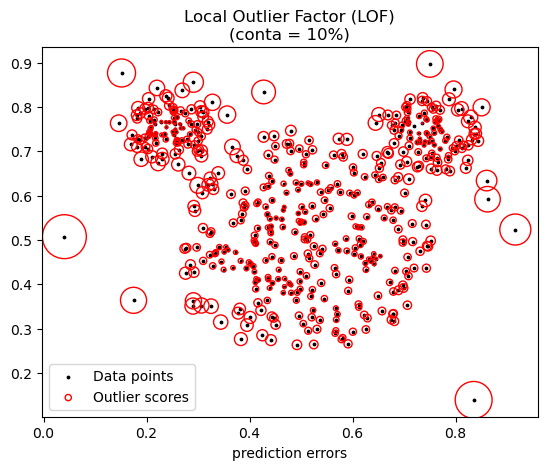

In [131]:
def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])


plt.scatter(mouse_data_lof_1.iloc[:, 0], mouse_data_lof_1.iloc[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (mouse_data_lof_1_scores.max() - mouse_data_lof_1_scores) / (mouse_data_lof_1_scores.max() - mouse_data_lof_1_scores.min())
scatter = plt.scatter(
    mouse_data_lof_1.iloc[:, 0],
    mouse_data_lof_1.iloc[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlabel("prediction errors")
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)
plt.title("Local Outlier Factor (LOF)\n(conta = 10%)")

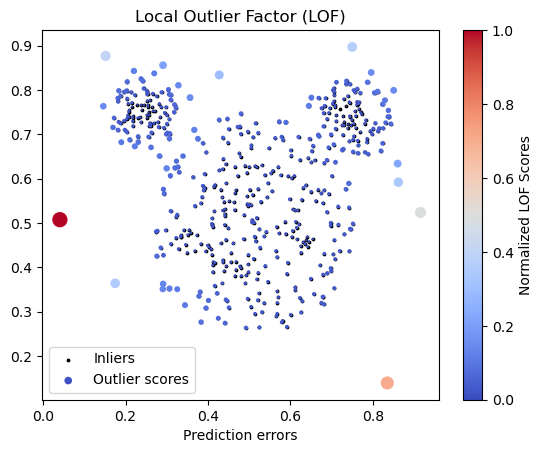

In [ ]:
# def update_legend_marker_size(handle, orig):
#     """Customize size of the legend marker."""
#     handle.update_from(orig)
#     handle.set_sizes([20])

# # Normalisation des scores pour ajuster la taille des points
# radius = (mouse_data_lof_1_scores.max() - mouse_data_lof_1_scores) / (
#     mouse_data_lof_1_scores.max() - mouse_data_lof_1_scores.min()
# )

# # Points normaux
# plt.scatter(
#     mouse_data_lof_1.iloc[:, 0],
#     mouse_data_lof_1.iloc[:, 1],
#     color="k",
#     s=3.0,
#     label="Inliers"
# )

# # Points anormaux avec tailles proportionnelles aux scores
# scatter = plt.scatter(
#     mouse_data_lof_1.iloc[:, 0],
#     mouse_data_lof_1.iloc[:, 1],
#     c=radius,  # Utilisation de couleurs (peut aussi être "red" pour une seule couleur)
#     cmap="coolwarm",  # Palette pour représenter les scores
#     s=100 * radius,  # Taille proportionnelle aux scores
#     label="Outlier scores"
# )

# # Ajustements de l'affichage
# plt.axis("tight")
# plt.xlabel("Prediction errors")
# plt.colorbar(scatter, label="Normalized LOF Scores")  # Ajouter une barre de couleur
# plt.legend(
#     handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
# )
# plt.title("Local Outlier Factor (LOF)")
# plt.show()


#### 2. Modèle LOF avec contamination à 2%

##### a. Model training

In [135]:
mouse_data_lof_2 = pd.read_table("mouse.txt", sep=" ", names=['x1', 'x2'])

Lof_model_2 = LocalOutlierFactor(
    n_neighbors=20,
    algorithm='auto', 
    leaf_size=30, 
    metric='minkowski', 
    p=2, 
    metric_params=None, 
    contamination=0.02, 
    novelty=False, 
    n_jobs=None)
    
y_pred_lof_2 = Lof_model_2.fit_predict(mouse_data_lof_2)
mouse_data_lof_2_scores = Lof_model_2.negative_outlier_factor_

##### b. Représentation graphique

Text(0.5, 1.0, 'Local Outlier Factor (LOF)\n(conta = 2%)')

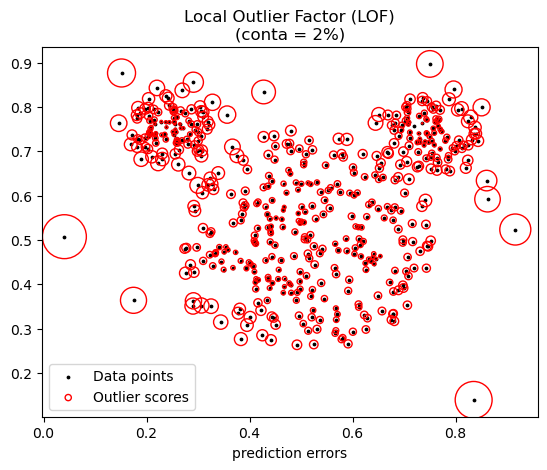

In [136]:
def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])


plt.scatter(mouse_data_lof_2.iloc[:, 0], mouse_data_lof_2.iloc[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (mouse_data_lof_2_scores.max() - mouse_data_lof_2_scores) / (mouse_data_lof_2_scores.max() - mouse_data_lof_2_scores.min())
scatter = plt.scatter(
    mouse_data_lof_2.iloc[:, 0],
    mouse_data_lof_2.iloc[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlabel("prediction errors")
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)
plt.title("Local Outlier Factor (LOF)\n(conta = 2%)")

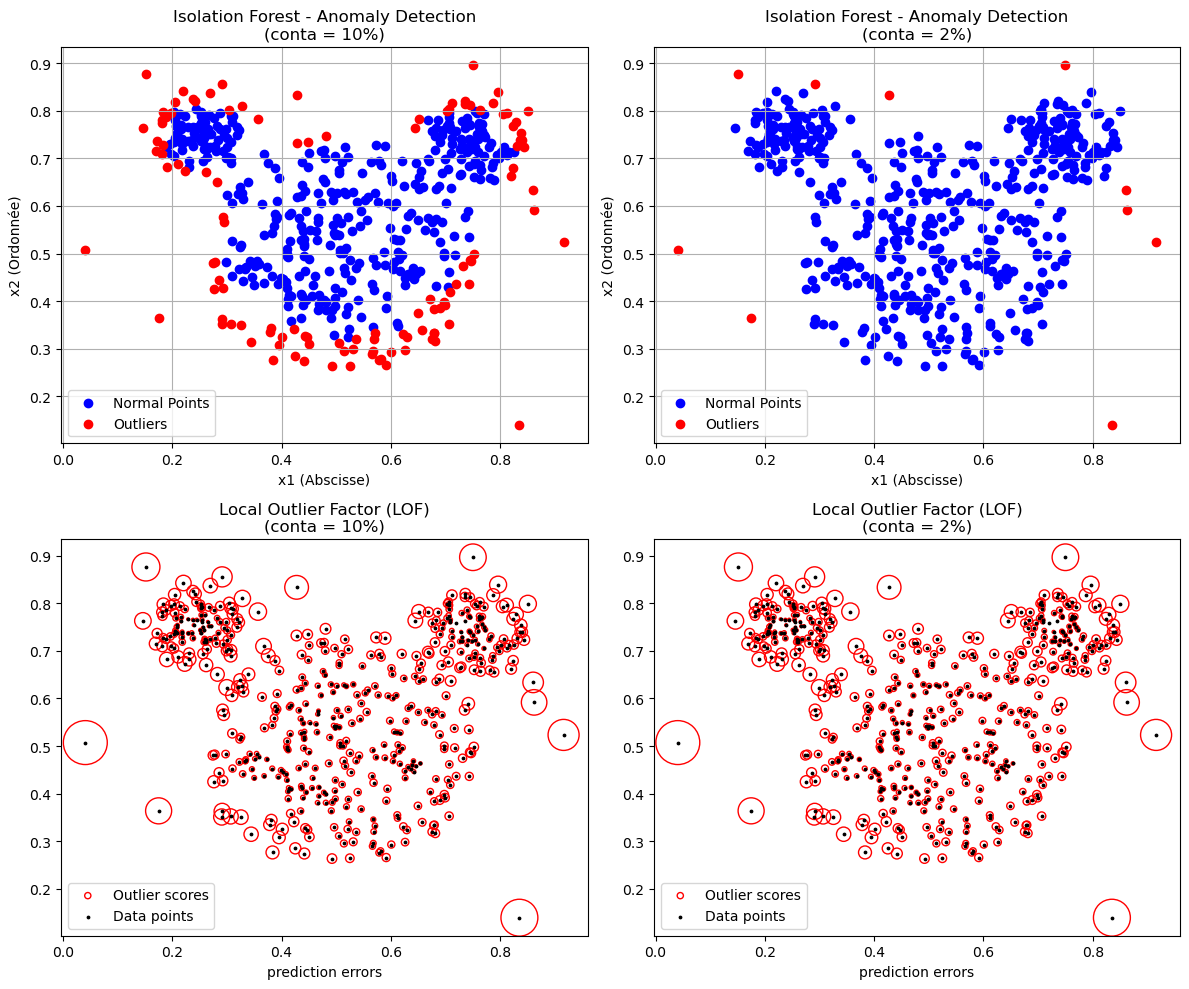

In [137]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection

# Créer une figure principale avec 2x2 sous-graphiques
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Figure 1 - Isolation Forest (conta = 10%)
axs[0, 0].scatter(normals['x1'], normals['x2'], color='blue', label='Normal Points')
axs[0, 0].scatter(outliers['x1'], outliers['x2'], color='red', label='Outliers')
axs[0, 0].set_xlabel('x1 (Abscisse)')
axs[0, 0].set_ylabel('x2 (Ordonnée)')
axs[0, 0].legend()
axs[0, 0].set_title('Isolation Forest - Anomaly Detection\n(conta = 10%)')
axs[0, 0].grid(True)

# Figure 2 - Isolation Forest (conta = 2%)
axs[0, 1].scatter(normals_1_bis['x1'], normals_1_bis['x2'], color='blue', label='Normal Points')
axs[0, 1].scatter(outliers_1_bis['x1'], outliers_1_bis['x2'], color='red', label='Outliers')
axs[0, 1].set_xlabel('x1 (Abscisse)')
axs[0, 1].set_ylabel('x2 (Ordonnée)')
axs[0, 1].legend()
axs[0, 1].set_title('Isolation Forest - Anomaly Detection\n(conta = 2%)')
axs[0, 1].grid(True)

# Figure 3 - Local Outlier Factor (conta = 10%)
radius = (mouse_data_lof_1_scores.max() - mouse_data_lof_1_scores) / (mouse_data_lof_1_scores.max() - mouse_data_lof_1_scores.min())
scatter = axs[1, 0].scatter(
    mouse_data_lof_1.iloc[:, 0],
    mouse_data_lof_1.iloc[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
axs[1, 0].scatter(mouse_data_lof_1.iloc[:, 0], mouse_data_lof_1.iloc[:, 1], color="k", s=3.0, label="Data points")
axs[1, 0].set_xlabel("prediction errors")
axs[1, 0].set_title("Local Outlier Factor (LOF)\n(conta = 10%)")
axs[1, 0].legend(
    handler_map={scatter: HandlerPathCollection(update_func=lambda h, o: h.update_from(o) or h.set_sizes([20]))}
)

# Figure 4 - Local Outlier Factor (conta = 2%)
radius = (mouse_data_lof_2_scores.max() - mouse_data_lof_2_scores) / (mouse_data_lof_2_scores.max() - mouse_data_lof_2_scores.min())
scatter = axs[1, 1].scatter(
    mouse_data_lof_2.iloc[:, 0],
    mouse_data_lof_2.iloc[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
axs[1, 1].scatter(mouse_data_lof_2.iloc[:, 0], mouse_data_lof_2.iloc[:, 1], color="k", s=3.0, label="Data points")
axs[1, 1].set_xlabel("prediction errors")
axs[1, 1].set_title("Local Outlier Factor (LOF)\n(conta = 2%)")
axs[1, 1].legend(
    handler_map={scatter: HandlerPathCollection(update_func=lambda h, o: h.update_from(o) or h.set_sizes([20]))}
)

# Ajuster les espaces entre les sous-graphes
fig.tight_layout()

## II. 